# Emerson Lab - Interview exercise

Below is simple way of processing a mechanism parts usage statistics.
1. Review the attached CSV files
    - SampleCSV.csv which is input data
    - ProductDescSample.csv which is augmentation data
2. Read files and create a complete data set
    - Any language you choose
    - Consideration that the Sample.csv may become much larger
3. Pick the most efficient format of file output and generate
4. Provide a PowerPoint that describes your solution and present


File Sample.csv

`SN` - The Part Serial number (Identifier)

`Run` time - test/measurement run time

`Site` - unused

`Operation` - unused

`Equipment` - unused

`Status.1` - Overall the part measurement status: OK if all tests passed, NOK any test failed

`Name` - test/measurement name

`Input` - input value for the test

`Output` - output value for the current measurement

`High_Limit` - Allowed highest value for the output

`Low_Limit` - Allowed lowest value for the output

`Status.2` - current test/measurement status

From the given sample I understand the following:

- For each part there is a group of tests to be done.
    - The test is described under the column `Name`
    - Each individual test may have outcome of Pass or Fail. I will take in consideration that there might be other values. So, only `Pass` is determined as a success for particular test
- For each test group if a particular test has failed the part is marked as `NOK` - Not okay
- The Part Serial number can differ. But multiple serial numbers might refer to the same type of part. In other words, SN has multiple Join on the Part_Desc.
    - the SN is unique and the group of tests is done once for each serial number
    - Multiple SN can have same Part_Desc
        - Individual parts have their own SN


In [1]:
from datetime import datetime
from typing import List, Tuple
from io import BytesIO

import pandas as pd
import matplotlib.pyplot as plt

from lib import email_utils

In [2]:
main_dataset_file_path = 'data/dummySamples2.csv'  # Main dataset to be parsed
serial_num_desc_file_path = 'data/dummyDescSample2.csv'  # Part numbers descriptions
report_to_email_addresses = ['hrayr.stepanyan.a@gmail.com']

In [3]:
columns = [
    'SN',
    'Run_Time',
    'Site',
    'Operation',
    'Equipment',
    'PartStatus',
    'Name',
    'Input',
    'Output',
    'High_Limit',
    'Low_Limit',
    'TestStatus',
]
dtypes = {
    'SN': str,
    'Run_Time': str,
    'Site': str,
    'Operation': str,
    'Equipment': str,
    'PartStatus': str,
    'Name': str,
    'Input': float,
    'Output': float,
    'High_Limit': float,
    'Low_Limit': float,
    'TestStatus': str,
}
parse_date = ['Run_Time']

# Parse in chunks and return as series

Let's calculate stats for the following:

- Total number of tests
- Number of Parts tested
- Number of failed individual tests for Part
- Failure rate

In [4]:
def parse_chunk(chunk: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    aggr_df = chunk.groupby(['Name', 'Part_Desc']).agg(
        TotalTests=('TestStatus', 'count'),
        FailedTests=('TestStatus', lambda x: (x != 'PASS').sum()),
        HighestOutput=('Output', 'max'),
        LowestOutput=('Output', 'min'),
    ).reset_index()
    parts_df = chunk['SN'].drop_duplicates()
    successful_sn_df = chunk.loc[chunk['PartStatus'] == 'OK']['SN'].drop_duplicates()

    return aggr_df, parts_df, successful_sn_df

In [5]:
df_reader = pd.read_csv(main_dataset_file_path, dtype=dtypes, parse_dates=parse_date, date_format='%m/%d/%y %H:%M:%s',
                        chunksize=10000)
aug = pd.read_csv(serial_num_desc_file_path)

global_metrics = pd.DataFrame(columns=['Name', 'Part_Desc', 'TotalTests', 'FailedTests', 'FailureRate'])
global_parts_df = pd.DataFrame(columns=['SN'])
global_successful_sn_df = pd.DataFrame(columns=['SN'])

for _chunk in df_reader:
    _chunk.columns = columns
    aug_df = _chunk.merge(aug, how='left', on='SN')
    _aggr_df, _parts_df, _successful_sn_df = parse_chunk(aug_df)
    global_metrics = pd.concat([global_metrics, _aggr_df]).groupby(['Name', 'Part_Desc'], as_index=False).agg(
        TotalTests=('TotalTests', 'sum'),
        FailedTests=('FailedTests', 'sum'),
        HighestOutput=('HighestOutput', 'max'),
        LowestOutput=('LowestOutput', 'min'),
    )

    global_parts_df = pd.concat([global_parts_df, _parts_df])
    global_successful_sn_df = pd.concat([global_successful_sn_df, _successful_sn_df])

global_metrics['FailureRate'] = global_metrics['FailedTests'] / global_metrics['TotalTests'] * 100
global_parts_df = global_parts_df.merge(aug, on='SN', how='left').groupby(['Part_Desc'], as_index=False).agg(
    parts_used=('SN', 'count'),
)
global_successful_sn_df = global_successful_sn_df.merge(
    aug, on='SN', how='left'
)
global_successful_sn_df_stats = global_successful_sn_df.groupby(['Part_Desc'], as_index=False).agg(parts_succeed=('SN', 'count'))

# Global metrics grouped and aggregated for particular part tests

['Name', 'Part_Desc', 'TotalTests', 'FailedTests', 'HighestOutput', 'LowestOutput', 'FailureRate']


,Name,Part_Desc,TotalTests,FailedTests,HighestOutput,LowestOutput,FailureRate
0,measure temperature,Gear_Box,7856,5939,45.00,25.00,75.598269
1,measure temperature,Hood_Cover,7752,5817,44.99,25.01,75.0387
2,measure temperature,Panel,7652,5812,45.00,25.00,75.953999
3,measure temperature,V8_Motor,7828,5822,45.00,25.00,74.374042
4,measure voltage,Gear_Box,7819,3911,1.00,-1.00,50.019184
5,measure voltage,Hood_Cover,7678,3949,1.00,-1.00,51.432665
6,measure voltage,Panel,7678,3904,1.00,-1.00,50.846575
7,measure voltage,V8_Motor,7737,3891,1.00,-1.00,50.29081


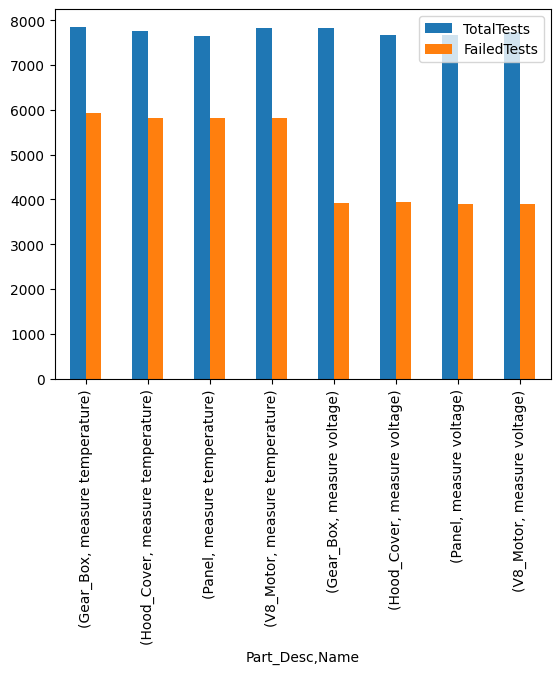

In [6]:
global_metrics_fig, global_metrics_ax = plt.subplots()
print(global_metrics.columns.tolist())
global_metrics.set_index(['Part_Desc', 'Name'])[['TotalTests', 'FailedTests']].plot(kind='bar', ax=global_metrics_ax)
global_metrics

# Overall parts usage statistics for the current report

,Part_Desc,parts_used
0,Gear_Box,3135
1,Hood_Cover,3086
2,Panel,3066
3,V8_Motor,3113


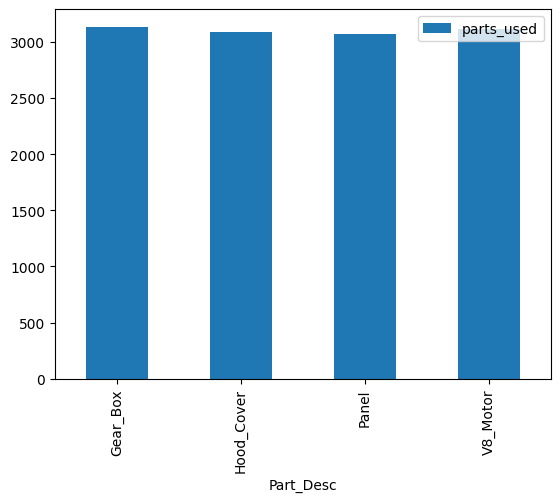

In [7]:
global_parts_df_fig, global_parts_df_ax = plt.subplots()

global_parts_df.set_index(['Part_Desc'])[['parts_used']].plot(kind='bar', ax=global_parts_df_ax)
global_parts_df

# How many parts have succeeded all the tests

,Part_Desc,parts_succeed
0,Gear_Box,23
1,Hood_Cover,23
2,Panel,26
3,V8_Motor,24


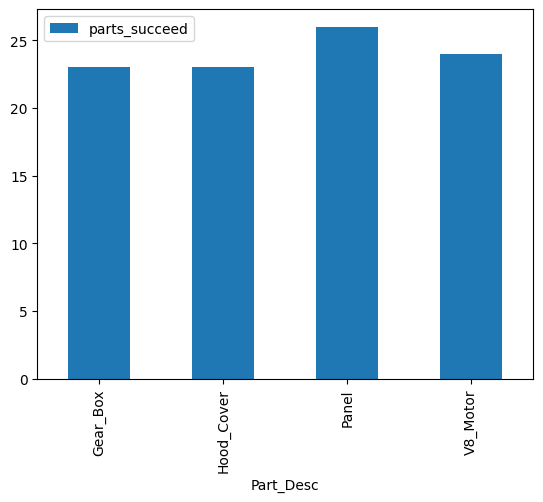

In [8]:
global_successful_sn_df_stats_fig, global_successful_sn_df_stats_ax = plt.subplots()
global_successful_sn_df_stats.set_index(['Part_Desc'])[['parts_succeed']].plot(kind='bar', ax=global_successful_sn_df_stats_ax)
global_successful_sn_df_stats

# List of parts with serial numbers succeeded the tests

In [9]:
global_successful_sn_df

,SN,Part_Desc
0,4044xf003,Hood_Cover
1,2034ma014,Gear_Box
2,1056yu040,V8_Motor
3,4040yj008,Hood_Cover
4,3059tq084,Panel
...,...,...
91,1073uc085,V8_Motor
92,4001uj070,Hood_Cover
93,4084za045,Hood_Cover
94,3037un086,Panel


In [10]:
def send_report(to: List[str], dataframes_with_plots: List[Tuple[str, pd.DataFrame, plt.Figure, plt.Axes]]) -> None:
    buffers = {}
    for name, df, fig, ax in dataframes_with_plots:
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        plt.close(fig)  # VERY IMPORTANT to avoid memory leak / global overlap

        buf.seek(0)
        buffers[f'{name}.png'] = buf

        # Create a BytesIO buffer
        csv_buffer = BytesIO()

        # Save to buffer as CSV (use .encode for bytes)
        csv_buffer.write(df.to_csv(index=False).encode('utf-8'))

        # Reset pointer to beginning of buffer
        csv_buffer.seek(0)
        buffers[f'{name}.csv'] = csv_buffer


    email_utils.send_email(to, f'Parts tests report - {datetime.now().strftime("%m/%d/%Y %I:%M:%S %p")}', 'In this email we include the testing results for product parts. See the attachments for details.', attachments=list(buffers.items()))


In [11]:

False and send_report(to=report_to_email_addresses, dataframes_with_plots=[
        ('FailureRates', global_metrics, global_metrics_fig, global_metrics_ax),
        ('PartItemsUsed', global_parts_df, global_parts_df_fig, global_parts_df_ax),
        ('PartsSuccessfulStats', global_successful_sn_df_stats, global_successful_sn_df_stats_fig, global_successful_sn_df_stats_ax),
    ])

False